<a href="https://colab.research.google.com/github/Catefishh/Image-Classifier-model/blob/main/Simple_Image_Classifier_model_using_fast_ai_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please change colab runtime to use '**T4**' instead for faster execution.

In [ ]:
# Step 1: Installing the necessary libraries.
!pip install fastai duckduckgo_search -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.4 MB/s eta 0:00:00


In [ ]:
# Step 2: Importing the necessary libraries.
from fastai.vision.all import *
from duckduckgo_search import DDGS
import os
from PIL import Image
import requests
from io import BytesIO
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# Step 3: Search and download the images from DuckDuckgo.
def search_and_download_images(query, folder, max_images=100):
    if not os.path.exists(folder):
        os.makedirs(folder)

    downloaded_count = 0
    removed_count = 0

    with DDGS() as ddgs:
        results = ddgs.images(query, max_results=max_images)
        for i, result in enumerate(results, 1):
            try:
                response = requests.get(result['image'], timeout=10)
                img = Image.open(BytesIO(response.content))

                img.save(f"{folder}/{query}_{i}.jpg")
                downloaded_count += 1
            except Exception as e:
                removed_count += 1
                print(f"Error downloading {result['image']}: {e}")

    print(f"Category: {query}.")
    print(f"Downloaded: {downloaded_count} images.")
    print(f"Removed: {removed_count} faulty images.\n")

categories = ['cat', 'dog']

for category in categories:
    search_and_download_images(category, f"data/{category}", max_images=50)

Error downloading https://besthqwallpapers.com/Uploads/25-2-2019/81784/brown-fluffy-cat-maine-coon-green-eyes-cute-animals-cats.jpg: cannot identify image file <_io.BytesIO object at 0x7e33b87509a0>
Error downloading https://image4.uhdpaper.com/wallpaper/kittens-cute-cat-animal-uhdpaper.com-4K-4.3346.jpg: cannot identify image file <_io.BytesIO object at 0x7e33b87509a0>
Error downloading https://ms.storyasset.link/GvMLkxrjQUdFDJMWxRDyH1bEFzh1/11-affectionate-cat-breeds-ms-mqhvxzghjj.jpg: cannot identify image file <_io.BytesIO object at 0x7e33b4cf3a10>
Error downloading https://www.rd.com/wp-content/uploads/2023/05/GettyImages-1341465008.jpg: cannot identify image file <_io.BytesIO object at 0x7e33b4c4db70>
Error downloading https://cattitudedaily.com/wp-content/uploads/2020/06/Canva-Aggressive-cat-roaring-1-scaled.jpg: cannot identify image file <_io.BytesIO object at 0x7e33b7445350>
Error downloading https://pics.clipartpng.com/Cat_PNG_Clip_Art-2580.png: cannot write mode RGBA as JPE

In [ ]:
# Step 4: Creating and preparing a dataset with the downloaded images.
path = Path("data")

def get_label(file_path):
    return file_path.parent.name

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

dls = dblock.dataloaders(path)

In [ ]:
# Step 5: Training the CNN model.
learn = vision_learner(dls, resnet34, metrics=accuracy)

learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.4MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.043076,1.160237,0.600000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.047766,0.813563,0.600000,00:03
1,0.837550,0.503869,0.666667,00:03
2,0.739686,0.273444,0.866667,00:06
3,0.615350,0.102079,1.000000,00:03
4,0.513338,0.038612,1.000000,00:03
5,0.430296,0.016034,1.000000,00:04
6,0.372181,0.007717,1.000000,00:03
7,0.323830,0.004487,1.000000,00:03
8,0.285764,0.003162,1.000000,00:03
9,0.255115,0.002736,1.000000,00:04


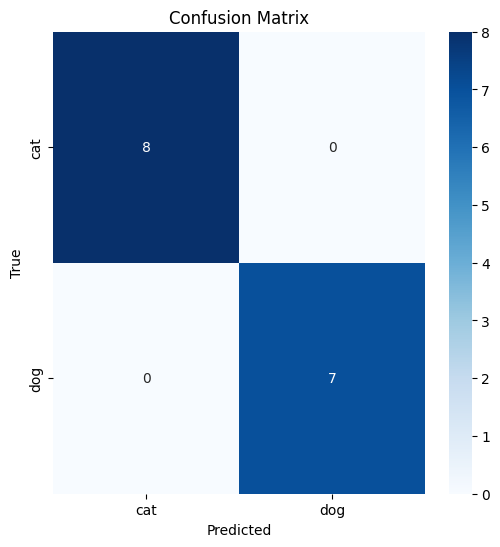

In [ ]:
# Step 6: Evaluating the model's performance with a confusion matrix.
preds, targs = learn.get_preds()

pred_classes = preds.argmax(dim=1)

cm = confusion_matrix(targs, pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Saving pexels-photo-2071882.jpeg to pexels-photo-2071882.jpeg


Prediction: cat
Probability: 1.0000


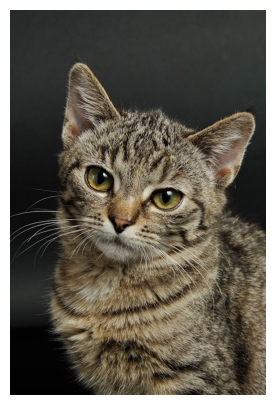

In [ ]:
# Step 7: Upload image(s) and make predictions.
def classify_uploaded_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = PILImage.create(filename)
        pred, _, probs = learn.predict(img)
        print(f"Prediction: {pred}")
        print(f"Probability: {probs.max().item():.4f}")
        img.show()

classify_uploaded_image()